In [ ]:
# Credit to UMich EECS442
# By Churong Ji
# Please do NOT copy for personal use
# Contact: churongj@andrew.cmu.edu
!pip install git+https://github.com/deepvision-class/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-fqg5bhx6
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-fqg5bhx6
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks, \
                    fix_random_seed, rel_error
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# parameters for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
# unpack as argument to torch functions, like so: **to_float
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [ ]:
def get_pascal_voc2007_data(image_root, split='train'):
  """
  Use torchvision.datasets
  https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCDetection
  """
  from torchvision import datasets

  train_dataset = datasets.VOCDetection(image_root, year='2007', image_set=split,
                                    download=True)
  
  return train_dataset

In [ ]:
# uncomment below to use the mirror link if the original link is broken
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget https://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/pascal_voc/VOCtrainval_06-Nov-2007.tar
train_dataset = get_pascal_voc2007_data('/content', 'train')
val_dataset = get_pascal_voc2007_data('/content', 'val')
# an example on the raw annotation
import json
print("============== Raw Annotation Example ==============")
print(json.dumps(train_dataset[1][1]['annotation'], indent=2))

--2023-05-02 06:05:52--  https://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/pascal_voc/VOCtrainval_06-Nov-2007.tar
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar.2’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  11.2MB/s    in 42s     

2023-05-02 06:06:35 (10.5 MB/s) - ‘VOCtrainval_06-Nov-2007.tar.2’ saved [460032000/460032000]

Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCtrainval_06-Nov-2007.tar to /content
Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCtrainval_06-Nov-2007.tar to /content
============== Raw Annotation Example ==============
{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC

In [ ]:
def pascal_voc2007_loader(dataset, batch_size, num_workers=0):
  """
  Data loader for Pascal VOC 2007.
  https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
  """
  from torch.utils.data import DataLoader
  # turn off shuffle so we can index the original image
  train_loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False, pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=voc_collate_fn)
  return train_loader


class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}


from torchvision import transforms

def voc_collate_fn(batch_lst, reshape_size=224):
    preprocess = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    
    batch_size = len(batch_lst)
    
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)
    
    max_num_box = max(len(batch_lst[i][1]['annotation']['object']) \
                      for i in range(batch_size))

    box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)
    w_list = []
    h_list = []
    img_id_list = []
    
    for i in range(batch_size):
      img, ann = batch_lst[i]
      w_list.append(img.size[0]) # image width
      h_list.append(img.size[1]) # image height
      img_id_list.append(ann['annotation']['filename'])
      img_batch[i] = preprocess(img)
      all_bbox = ann['annotation']['object']
      if type(all_bbox) == dict: # inconsistency in the annotation file
        all_bbox = [all_bbox]
      for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_batch[i][bbox_idx] = torch.Tensor([float(bbox['xmin']), float(bbox['ymin']),
          float(bbox['xmax']), float(bbox['ymax']), class_to_idx[obj_cls]])
    
    h_batch = torch.tensor(h_list)
    w_batch = torch.tensor(w_list)

    return img_batch, box_batch, w_batch, h_batch, img_id_list

In [ ]:
import random

def filter_dataset_with_class(dataset, class_name, ratio):
    images_with_class = []
    images_without_class = []
    final_images = []
    for img, ann in dataset:
        objects = ann['annotation']['object']
        if type(objects) == dict:
            objects = [objects]
        names = [obj['name'] for obj in objects]
        if class_name in names:
            images_with_class.append((img, ann))
        else:
            images_without_class.append((img, ann))
    target_num = len(images_with_class)
    non_target_num = len(images_without_class)
    cur_ratio = target_num / (target_num + non_target_num)
    if ratio > cur_ratio:
        final_images.extend(images_with_class)
        final_images.extend(random.sample(images_without_class, int((1 - ratio) / ratio * target_num)))
    else:
        final_images.extend(images_without_class)
        final_images.extend(random.sample(images_with_class, int(ratio / (1 - ratio) * non_target_num)))
    random.shuffle(final_images)
    return final_images

In [ ]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training

In [ ]:
# no cat class included in the train dataset for the initial training at the cloud
train_dataset_no_cat = filter_dataset_with_class(train_dataset, 'cat', 0.1)

In [ ]:
train_loader = pascal_voc2007_loader(train_dataset_no_cat, 10, True)
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = next(train_loader_iter)


print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)

print('Image 1 has only two annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nImage 2 has six annotated objects:, so ann[2] is not padded:')
print(ann[2])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 11, 5])
Image 1 has only two annotated objects, so ann[1] is padded with -1:
tensor([[ 54.,  67., 500., 318.,  18.],
        [ 33.,   1.,  71.,  20.,   6.],
        [  2.,   1.,  40.,  21.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Image 2 has six annotated objects:, so ann[2] is not padded:
tensor([[193.,  38., 339., 348.,   2.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  

In [ ]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred pixels in
  width/height while the activation map is of size 7x7.

  Input:
  - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
  - w_pixel: Number of pixels in the width side of the original image, of shape B
  - h_pixel: Number of pixels in the height side of the original image, of shape B
  - w_amap: Number of pixels in the width side of the activation map, scalar
  - h_amap: Number of pixels in the height side of the activation map, scalar
  - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

  Output:
  - resized_bbox: Resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
  
  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox

In [ ]:
def data_visualizer(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image. Support both GT box input and proposal 
  input.
  
  Input:
  - img: PIL Image input
  - idx_to_class: Mapping from the index (0-19) to the class name
  - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
          the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
  - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
          N' is the number of predicted boxes, 6 indicates
          (x_tl, y_tl, x_br, y_br, class, object confidence score)
  """

  img_copy = np.array(img).astype('uint8')

  if bbox is not None:
    for bbox_idx in range(bbox.shape[0]):
      one_bbox = bbox[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (255, 0, 0), 2)
      if bbox.shape[1] > 4: # if class info provided
        obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
        cv2.putText(img_copy, '%s' % (obj_cls),
                  (one_bbox[0], one_bbox[1]+15),
                  cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  if pred is not None:
    for bbox_idx in range(pred.shape[0]):
      one_bbox = pred[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (0, 255, 0), 2)
      
      if pred.shape[1] > 4: # if class and conf score info provided
        obj_cls = idx_to_class[pred[bbox_idx][4].item()]
        conf_score = pred[bbox_idx][5].item()
        cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                    (one_bbox[0], one_bbox[1]+15),
                    cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

In [ ]:
# default examples for visualization
fix_random_seed(1)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.as_tensor(w_list, **to_float_cuda)
h_list = torch.as_tensor(h_list, **to_float_cuda)
box_list = torch.as_tensor(box_list, **to_float_cuda)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a') # on activation map coordinate system

In [ ]:
# # visualize GT boxes
# for i in range(len(img_list)):
#   valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
#   data_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

In [ ]:
class FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    from torchvision import models
    from torchsummary import summary

    self.mobilenet = models.mobilenet_v2(pretrained=True)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 7 x 7

    for i in self.mobilenet.named_parameters():
      i[1].requires_grad = True # fine-tune all parameters

    if verbose:
      summary(self.mobilenet.cuda(), (3, reshape_size, reshape_size))
  
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x224x224
    
    Outputs:
    - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
    """
    num_img = img.shape[0]
    
    img_prepro = img

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

In [ ]:
model = FeatureExtractor(verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).

  Inputs:
  - batch_size, B
  - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
  - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
  - W' and H' are always 7 in our case while w and h might vary.
  
  Outputs:
  grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid


In [ ]:
# # visualization
# # simply create an activation grid where the cells are in green and the centers in red
# # you should see the entire image divided by a 7x7 grid, with no gaps on the edges

# grid_list = GenerateGrid(w_list.shape[0])

# center = torch.cat((grid_list, grid_list), dim=-1)
# grid_cell = center.clone()
# grid_cell[:, :, :, [0, 1]] -= 1. / 2.
# grid_cell[:, :, :, [2, 3]] += 1. / 2.
# center = coord_trans(center, w_list, h_list)
# grid_cell = coord_trans(grid_cell, w_list, h_list)

# for img, anc, grid in zip(img_list, center, grid_cell):
#   data_visualizer(img, idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))

In [ ]:
def GenerateProposal(grids, offsets):
  """
  Proposal generator.

  Inputs:
  - grids: Activation grids, of shape (B, H', W', 2). Grid centers are 
  represented by their coordinates in the activation map.
  - offsets: Transformations obtained from the Prediction Network 
    of shape (B, A, H', W', 4) that will be used to generate proposals region 
    proposals. The transformation offsets[b, a, h, w] = (tx, ty, tw, th) will be 
    applied to the grids[b, a, h, w]. 
    Assume that tx and ty are in the range
    (-0.5, 0.5) and h,w are normalized and thus in the range (0, 1).

  Outputs:
  - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
    coordinates of their top-left and bottom-right corners. Using the
    transform offsets[b, a, h, w] and girds[b, a, h, w] should give the proposals.
    The expected parametrization of the proposals is (xtl, ytl, xbr, ybr). 
  
  CAUTION: 
    Notice that the offsets here are parametrized as (x, y, w, h). 
    The proposals you return need to be of the form (xtl, ytl, xbr, ybr).
  """
  proposals = None
  
  #############################################################################
  # TODO: Given grid coordinates and the proposed offset for each bounding    #
  # box, compute the proposal coordinates using the transformation formulas   #
  # above.                                                                    #
  #############################################################################
  # 1. Follow the formulas above to convert the grid centers into proposals.

  # 2. Convert the proposals into (xtl, ytl, xbr, ybr) coordinate format as 
  # mentioned in the header and in the cell above that.

  temp = grids.clone()
  new_grids = temp[:, None, :, :, :]
  temp_proposals = offsets.clone()
  proposals = offsets.clone()
  temp_proposals[:, :, :, :, 0] = new_grids[:, :, :, :, 0] + offsets[:, :, :, :, 0]
  temp_proposals[:, :, :, :, 1] = new_grids[:, :, :, :, 1] + offsets[:, :, :, :, 1]
  temp_proposals[:, :, :, :, 2] = offsets[:, :, :, :, 2] * 7
  temp_proposals[:, :, :, :, 3] = offsets[:, :, :, :, 3] * 7

  proposals[:, :, :, :, 0] = temp_proposals[:, :, :, :, 0] - temp_proposals[:, :, :, :, 2] / 2
  proposals[:, :, :, :, 1] = temp_proposals[:, :, :, :, 1] - temp_proposals[:, :, :, :, 3] / 2
  proposals[:, :, :, :, 2] = temp_proposals[:, :, :, :, 0] + temp_proposals[:, :, :, :, 2] / 2
  proposals[:, :, :, :, 3] = temp_proposals[:, :, :, :, 1] + temp_proposals[:, :, :, :, 3] / 2

  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################                        

  return proposals

In [ ]:
def IoU(proposals, bboxes):
  """
  Compute intersection over union between sets of bounding boxes.

  Inputs:
  - proposals: Proposals of shape (B, A, H', W', 4). These should be parametrized
    as (xtl, ytl, xbr, ybr).
  - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
    Each ground-truth box is represented as tuple (x_tl, y_tl, x_br, y_br, class).
    If image i has fewer than N boxes, then bboxes[i] will be padded with extra
    rows of -1.
  
  Outputs:
  - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
    the IoU between ith element of proposals[b] and bboxes[b, n].

  For this implementation you DO NOT need to filter invalid proposals or boxes;
  in particular you don't need any special handling for bboxxes that are padded
  with -1.
  """
  iou_mat = None 

  #############################################################################
  # TODO: Compute the Intersection over Union (IoU) on proposals and GT boxes.#
  # No need to filter invalid proposals/bboxes (i.e., allow region area <= 0).#
  # However, you need to make sure to compute the IoU correctly (it should be #
  # 0 in those cases.                                                         # 
  # You need to ensure your implementation is efficient (no for loops).       #
  # HINT:                                                                     #
  # IoU = Area of Intersection / Area of Union, where                         #
  # Area of Union = Area of Proposal + Area of BBox - Area of Intersection    #
  # and the Area of Intersection can be computed using the top-left corner and#
  # bottom-right corner of proposal and bbox. Think about their relationships.#
  #############################################################################

  B, A, H, W, _ = proposals.size()
  _, N, _ = bboxes.size()
  prop = proposals.reshape(B, A*H*W, 4)
  prop = torch.unsqueeze(prop, 2)
  bbox = torch.unsqueeze(bboxes, 1)
  
  prop_area = (prop[:, :, :, 2] - prop[:, :, :, 0]) * (prop[:, :, :, 3] - prop[:, :, :, 1])
  bbox_area = (bbox[:, :, :, 2] - bbox[:, :, :, 0]) * (bbox[:, :, :, 3] - bbox[:, :, :, 1])
  prop_area = prop_area.repeat(1, 1, N)
  bbox_area = bbox_area.repeat(1, A*H*W, 1)

  xl = torch.maximum(prop[:, :, :, 0], bbox[:, :, :, 0])
  yl = torch.maximum(prop[:, :, :, 1], bbox[:, :, :, 1])
  xr = torch.minimum(prop[:, :, :, 2], bbox[:, :, :, 2])
  yr = torch.minimum(prop[:, :, :, 3], bbox[:, :, :, 3])
  inter_area = (xr - xl) * (yr - yl)
  inter_area[xr < xl] = 0
  inter_area[yr < yl] = 0
  inter_area[inter_area<0] = 0

  iou_mat = inter_area / (prop_area + bbox_area - inter_area)

  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################

  return iou_mat

In [ ]:
# simple sanity check

width, height = torch.tensor([35, 35], **to_float_cuda), torch.tensor([40, 40], **to_float_cuda)
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], **to_float_cuda)
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], **to_float_cuda)

result = IoU(sample_proposals, sample_bbox)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], **to_float_cuda)
print('simple iou_mat error: ', rel_error(expected_result, result))


simple iou_mat error:  0.0


In [ ]:
class PredictionNetwork(nn.Module):
  def __init__(self, in_dim, hidden_dim=128, num_bboxes=2, num_classes=20, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0 and num_bboxes != 0)
    self.num_classes = num_classes
    self.num_bboxes = num_bboxes

    # Here we set up a network that will predict outputs for all bounding boxes.
    # This network has a 1x1 convolution layer with `hidden_dim` filters, 
    # followed by a Dropout layer with `p=drop_ratio`, a Leaky ReLU 
    # nonlinearity, and finally another 1x1 convolution layer to predict all
    # outputs. The network is stored in `self.net`, and has shape 
    # (B, 5*A+C, 7, 7), where the 5 predictions are in the order 
    # (x, y, w, h, conf_score), with A = `self.num_bboxes`
    # and C = `self.num_classes`.                                 
    
    self.in_dim = in_dim
    self.hidden_dim = hidden_dim
    self.drop_ratio = drop_ratio
    out_dim = 5*self.num_bboxes + self.num_classes

    layers = [
        torch.nn.Conv2d(self.in_dim, self.hidden_dim, kernel_size=1),
        torch.nn.Dropout(p=self.drop_ratio),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Conv2d(self.hidden_dim,out_dim,kernel_size=1),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self, features):
    """
    Run the forward pass of the network to predict outputs given features
    from the backbone network.

    Inputs:
    - features: Tensor of shape (B, in_dim, 7, 7) giving image features computed
      by the backbone network.

    Outputs:
    - bbox_xywh: Tensor of shape (B, A, 4, H, W) giving predicted offsets for 
      all bounding boxes.
    - conf_scores: Tensor of shape (B, A, H, W) giving predicted classification
      scores for all bounding boxes.
    - cls_scores: Tensor of shape (B, C, H, W) giving classification scores for
      each spatial position.
    """
    bbox_xywh, conf_scores, cls_scores = None, None, None
    
    ###########################################################################
    # TODO: Implement the forward pass of the PredictionNetwork.              #
    # - Use features to predict bbox_xywh (offsets), conf_scores, and         #
    # class_scores.                                                           #
    # - Make sure conf_scores is between 0 and 1 by squashing the             #
    # network output with a sigmoid.                                          #
    # - The first two elements t^x and t^y of offsets should be between -0.5  #
    # and 0.5. You can achieve this by squashing with a sigmoid               #
    # and subtracting 0.5.                                                    #
    # - The last two elements of bbox_xywh w and h should be normalized,      #
    # i.e. squashed with a sigmoid between 0 and 1.                           #
    #                                                                         #
    # Note: In the 5A+C dimension, the first 5*A would be bounding box        # 
    # offsets, and next C will be class scores.                               #
    ###########################################################################

    outputs = self.net(features)

    B = features.size()[0]
    A, H, W = 2, 7, 7

    cls_scores = outputs[:, 5*self.num_bboxes:, :, :].clone()

    bbox_xywh = outputs[:, [0, 1, 2, 3, 5, 6, 7, 8], :, :]
    bbox_xywh = bbox_xywh.reshape(B, A, 4, H, W)
    bbox_xywh = torch.sigmoid(bbox_xywh).clone()
    bbox_xywh[:, :, 0:2, :, :] = bbox_xywh[:, :, 0:2, :, :] - 0.5

    conf_scores = outputs[:, [4, 9], :, :]
    conf_scores = torch.sigmoid(conf_scores).clone()

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    
    
    # You can uncomment these lines when training for a few iterations to 
    # check if your offets are within the expected bounds.
    
    # print("Checking offset bounds in Prediction Network...")
    # assert bbox_xywh[:, :, 0:2].max() <= 0.5 and bbox_xywh[:, :, 0:2].min() >= -0.5, 'invalid offsets (x, y) values'
    # assert bbox_xywh[:, :, 2:4].max() <= 1 and bbox_xywh[:, :, 2:4].min() >= 0, 'invalid offsets (w, h) values'
    # print("Check passed!")

    return bbox_xywh, conf_scores, cls_scores

In [ ]:
def ReferenceOnActivatedBboxes(bboxes, gt_bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3):
  """
  Determine the activated (positive) and negative bboxes for model training.

  A grid cell is responsible for predicting a GT box if the center of
  the box falls into that cell.
  Implementation details: First compute manhattan distance between grid cell centers
  (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
  perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
  responsible for GT boxes (convert to x and y). Among all the bboxes associated with
  the activate grids, the bbox with the largest IoU with the GT box is responsible to
  predict (regress to) the GT box.
  Note: One bbox might match multiple GT boxes.

  Main steps include:
  i) Decide activated and negative bboxes based on the IoU matrix.
  ii) Compute GT confidence score/offsets/object class on the positive proposals.
  iii) Compute GT confidence score on the negative proposals.
  
  Inputs:
  - bboxes: Bounding boxes, of shape BxAxH’xW’x4
  - gt_bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
            5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
  - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
  - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
  - pos_thresh: Positive threshold value
  - neg_thresh: Negative threshold value

  Outputs:
  - activated_anc_ind: Index on activated bboxes, of shape M, where M indicates the 
                       number of activated bboxes
  - negative_anc_ind: Index on negative bboxes, of shape M
  - GT_conf_scores: GT IoU confidence scores on activated bboxes, of shape M
  - GT_offsets: GT offsets on activated bboxes, of shape Mx4. They are denoted as
                \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
  - GT_class: GT class category on activated bboxes, essentially indexed from gt_bboxes[:, :, 4],
              of shape M
  - activated_anc_coord: Coordinates on activated bboxes (mainly for visualization purposes)
  - negative_anc_coord: Coordinates on negative bboxes (mainly for visualization purposes)
  """


  B, A, h_amap, w_amap, _ = bboxes.shape
  N = gt_bboxes.shape[1]

  # activated/positive bboxes
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)

  bbox_mask = (gt_bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
  bbox_centers = (gt_bboxes[:, :, 2:4] - gt_bboxes[:, :, :2]) / 2. + gt_bboxes[:, :, :2] # BxNx2

  mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
  min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
  grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

  reshaped_iou_mat = iou_mat.view(B, A, -1, N)
  anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
  anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
  activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
  activated_anc_mask &= bbox_mask.unsqueeze(1)
  
  # one bbox could match multiple GT boxes
  activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
  GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
  gt_bboxes = gt_bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
  GT_class = gt_bboxes[:, 4].long()
  gt_bboxes = gt_bboxes[:, :4]
  activated_anc_ind = (activated_anc_ind.float() / activated_anc_mask.shape[-1]).long()

  print('number of pos proposals: ', activated_anc_ind.shape[0])
  
  activated_anc_coord = bboxes.reshape(-1, 4)[activated_anc_ind]
  
  activated_grid_coord = grid.repeat(1,A,1,1,1).reshape(-1, 2)[activated_anc_ind]

  
  # GT offsets
  
  # bbox are x_tl, y_tl, x_br, y_br
  # offsets are t_x, t_y, t_w, t_h

  # Grid: (B, H, W, 2) -> This will be used to calculate center offsets
  # w, h offsets are not offsets but normalized w,h themselves.
  
  wh_offsets = torch.sqrt((gt_bboxes[:, 2:4] - gt_bboxes[:, :2])/7.)
  assert torch.max((gt_bboxes[:, 2:4] - gt_bboxes[:, :2])/7.) <= 1, "w and h targets not normalised, should be between 0 and 1"

  xy_offsets = (gt_bboxes[:, :2] + gt_bboxes[:, 2:4])/(2.) - activated_grid_coord
  
  assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
    "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
    torch.max(torch.abs(xy_offsets)))

  GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

  # negative bboxes
  negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = bboxes.reshape(-1, 4)[negative_anc_ind.view(-1)]
  
  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

In [ ]:
def ConfScoreRegression(conf_scores, GT_conf_scores):
  """
  Use sum-squared error as in YOLO

  Inputs:
  - conf_scores: Predicted confidence scores
  - GT_conf_scores: GT confidence scores
  
  Outputs:
  - conf_score_loss
  """
  # the target conf_scores for negative samples are zeros
  GT_conf_scores = torch.cat((torch.ones_like(GT_conf_scores), \
                              torch.zeros_like(GT_conf_scores)), dim=0).view(-1, 1)
  
  conf_score_loss = torch.sum((conf_scores - GT_conf_scores)**2) * 1. / GT_conf_scores.shape[0]
  return conf_score_loss

In [ ]:
def BboxRegression(offsets, GT_offsets):
  """"
  Use sum-squared error as in YOLO
  For both xy and wh.
  NOTE: In YOLOv1, the authors use sqrt(w) and sqrt(h) for normalized w and h
  (read paper for more details) and thus both offsets and GT_offsets will 
  be having (x, y, sqrt(w), sqrt(h)) parametrization of the coodinates. 


  Inputs:
  - offsets: Predicted box offsets
  - GT_offsets: GT box offsets
  
  Outputs:
  - bbox_reg_loss
  """

  bbox_reg_loss = torch.sum((offsets - GT_offsets)**2) * 1. / GT_offsets.shape[0]
  return bbox_reg_loss

In [ ]:
def ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind):
  """"
  Use softmax loss

  Inputs:
  - class_prob: Predicted class logits
  - GT_class: GT box class label
  - batch_size: the batch size to compute loss over
  - anc_per_img: anchor indices for each image
  - activated_anc_ind: indices for positive anchors
  
  Outputs:
  - object_cls_loss, the classification loss for object detection
  """
  # average within sample and then average across batch
  # such that the class pred would not bias towards dense popular objects like `person`

  all_loss = F.cross_entropy(class_prob, GT_class, reduction='none') # , reduction='sum') * 1. / batch_size
  object_cls_loss = 0
  for idx in range(batch_size):
    anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
    object_cls_loss += all_loss[anc_ind_in_img].sum() * 1. / torch.sum(anc_ind_in_img)
  object_cls_loss /= batch_size
  # object_cls_loss = F.cross_entropy(class_prob, GT_class, reduction='sum') * 1. / batch_size

  return object_cls_loss

In [ ]:
class SingleStageDetector(nn.Module):
  def __init__(self):
    super().__init__()

    self.feat_extractor = FeatureExtractor()
    self.num_classes = 20
    self.num_bboxes = 2
    self.pred_network = PredictionNetwork(1280, num_bboxes=2, \
                                          num_classes=self.num_classes)
  

  def forward(self, images, bboxes):
    """
    Training-time forward pass for the single-stage detector.

    Inputs:
    - images: Input images, of shape (B, 3, 224, 224)
    - bboxes: GT bounding boxes of shape (B, N, 5) (padded)

    Outputs:
    - total_loss: Torch scalar giving the total loss for the batch.
    """
    # weights to multiple to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 1 # for offsets
    w_cls = 1 # for class_prob

    total_loss = None             

    # 1. Feature extraction
    features = self.feat_extractor(images)

    # 2. Grid generator
    grid_list = GenerateGrid(images.shape[0])

    # 3. Prediction Network
    bbox_xywh, conf_scores, cls_scores = self.pred_network(features)
    # (B, A, 4, H, W), (B, A, H, W), (B, C, H, W)
    
    B, A, _, H, W = bbox_xywh.shape
    bbox_xywh = bbox_xywh.permute(0, 1, 3, 4, 2) # (B, A, H, W, 4)

    assert bbox_xywh.max() <= 1 and bbox_xywh.min() >= -0.5, 'invalid offsets values'

    # 4. Calculate the proposals
    proposals = GenerateProposal(grid_list, bbox_xywh)

    # 5. Compute IoU
    iou_mat = IoU(proposals, bboxes)

    # 7. Using the activated_anc_ind, select the activated conf_scores, bbox_xywh, cls_scores
    activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, _, _ \
      = ReferenceOnActivatedBboxes(bbox_xywh, bboxes, grid_list, iou_mat, neg_thresh=0.3)

    conf_scores = conf_scores.view(B, A, 1, H, W)
    pos = self._extract_bbox_data(conf_scores, activated_anc_ind)
    neg = self._extract_bbox_data(conf_scores, negative_anc_ind)
    conf_scores = torch.cat([pos, neg], dim = 0)

    # 6. The loss function
    bbox_xywh[:, :, :, :, 2:4] = torch.sqrt(bbox_xywh[:, :, :, :, 2:4])

    # assert bbox_xywh[:, :, :, :, :2].max() <= 0.5 and bbox_xywh[:, :, :, :, :2].min() >= -0.5, 'invalid offsets values'
    # assert bbox_xywh[:, :, :, :, :2:4].max() <= 1 and bbox_xywh[:, :, :, :, 2:4].min() >= 0, 'invalid offsets values'
    
    offsets = self._extract_bbox_data(bbox_xywh.permute(0, 1, 4, 2, 3), activated_anc_ind)
    cls_scores = self._extract_class_scores(cls_scores, activated_anc_ind)
    anc_per_img = torch.prod(torch.tensor(bbox_xywh.shape[1:-1])) # use as argument in ObjectClassification
    ###########################################################################
    # TODO: Compute conf_loss, reg_loss, cls_loss, total_loss using the       #
    # functions defined in part (e).                                           #
    # - total_loss is the sum of the three other losses.                      #                                                                
    ###########################################################################
    # 8. Compute losses

    conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores)
    reg_loss = BboxRegression(offsets, GT_offsets)
    cls_loss = ObjectClassification(cls_scores, GT_class, B, anc_per_img, activated_anc_ind)

    total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss

    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  
    print('(weighted) conf loss: {:.4f}, reg loss: {:.4f}, cls loss: {:.4f}'.format(conf_loss, reg_loss, cls_loss))

    return total_loss
  
  def inference(self):
    raise NotImplementedError
  
  def _extract_bbox_data(self, bbox_data, bbox_idx):
    """
    Inputs:
    - bbox_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A bboxes at each point in an H x W grid.
    - bbox_idx: int64 Tensor of shape (M,) giving bbox indices to extract

    Returns:
    - extracted_bboxes: Tensor of shape (M, D) giving bbox data for each
      of the bboxes specified by bbox_idx.
    """
    B, A, D, H, W = bbox_data.shape
    bbox_data = bbox_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_bboxes = bbox_data[bbox_idx]
    return extracted_bboxes
  
  def _extract_class_scores(self, all_scores, bbox_idx):
    """
    Inputs:
    - all_scores: Tensor of shape (B, C, H, W) giving classification scores for
      C classes at each point in an H x W grid.
    - bbox_idx: int64 Tensor of shape (M,) giving the indices of bboxes at
      which to extract classification scores

    Returns:
    - extracted_scores: Tensor of shape (M, C) giving the classification scores
      for each of the bboxes specified by bbox_idx.
    """
    B, C, H, W = all_scores.shape
    A = self.num_bboxes
    all_scores = all_scores.contiguous().permute(0, 2, 3, 1).contiguous()
    all_scores = all_scores.view(B, 1, H, W, C).expand(B, A, H, W, C)
    all_scores = all_scores.reshape(B * A * H * W, C)
    extracted_scores = all_scores[bbox_idx]
    return extracted_scores


In [ ]:
def DetectionSolver(detector, train_loader, learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, **kwargs):
  """
  Run optimization to train the model.
  """

  # ship model to GPU
  detector.to(**to_float_cuda)

  # optimizer setup
  from torch import optim
  # optimizer = optim.Adam(
  optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  loss_history = []
  detector.train()
  for i in range(num_epochs):
    start_t = time.time()
    for iter_num, data_batch in enumerate(train_loader):
      images, boxes, w_batch, h_batch, _ = data_batch
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      # print(resized_boxes)
      images = images.to(**to_float_cuda)
      resized_boxes = resized_boxes.to(**to_float_cuda)

      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()

      print('(Iter {} / {})'.format(iter_num, len(train_loader)))

    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

  return loss_history

number of pos proposals:  315
(weighted) conf loss: 0.2512, reg loss: 0.3113, cls loss: 3.0615
(Iter 0 / 17)
number of pos proposals:  274
(weighted) conf loss: 0.2541, reg loss: 0.2936, cls loss: 2.8157
(Iter 1 / 17)
number of pos proposals:  281
(weighted) conf loss: 0.2485, reg loss: 0.2796, cls loss: 2.4905
(Iter 2 / 17)
number of pos proposals:  351
(weighted) conf loss: 0.2603, reg loss: 0.3021, cls loss: 2.4387
(Iter 3 / 17)
number of pos proposals:  293
(weighted) conf loss: 0.2401, reg loss: 0.2714, cls loss: 2.3984
(Iter 4 / 17)
number of pos proposals:  321
(weighted) conf loss: 0.2436, reg loss: 0.2843, cls loss: 2.4147
(Iter 5 / 17)
number of pos proposals:  299
(weighted) conf loss: 0.2345, reg loss: 0.2631, cls loss: 2.1573
(Iter 6 / 17)
number of pos proposals:  353
(weighted) conf loss: 0.2293, reg loss: 0.2640, cls loss: 1.8629
(Iter 7 / 17)
number of pos proposals:  306
(weighted) conf loss: 0.2328, reg loss: 0.2495, cls loss: 1.9292
(Iter 8 / 17)
number of pos propo

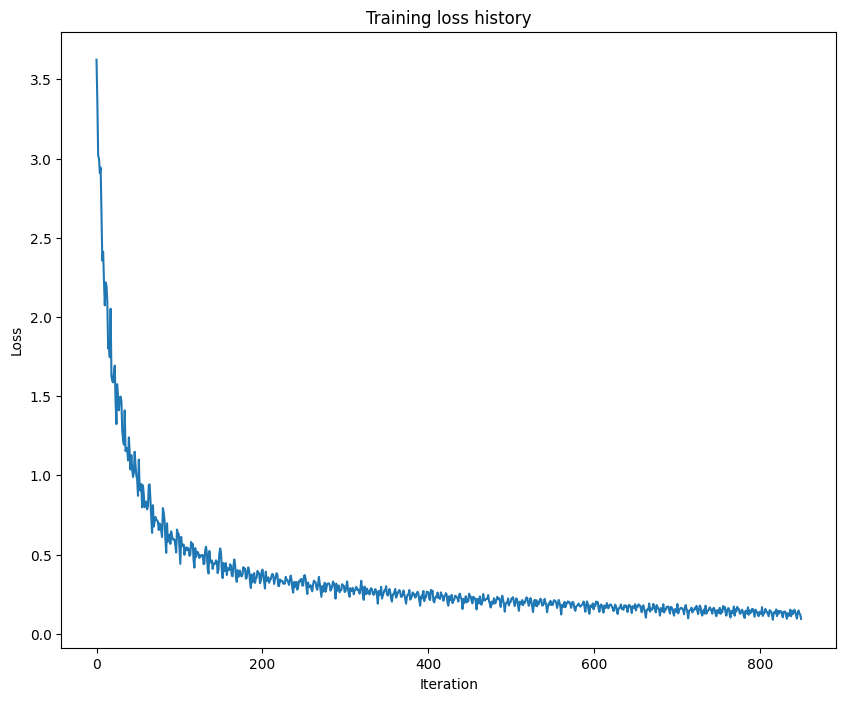

In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset_no_cat, 100) # a new loader

lr = 5e-2
num_epochs = 50
yolo_detector = SingleStageDetector()
loss_history_train = DetectionSolver(yolo_detector, train_loader, learning_rate=lr, num_epochs=num_epochs)

In [ ]:
torch.save(yolo_detector.state_dict(), 'yolo_pretrained_detector.pt')